# Generating Images of Cats and Dogs -- Group 35
## GAN
Gustav Lahti (lahtig@student.chalmers.se) and Agnes Mårdh (agnesma@student.chalmers.se) 

## Imports
Importing all the necessary libraries and other useful initialisations.

In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils

import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

import matplotlib.pyplot as plt

# Just for benchmarking
import time

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Initialising datasets
We are using the same folder structure as for home assignment 1.

In [4]:
# Root for images
dataroot = "train"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

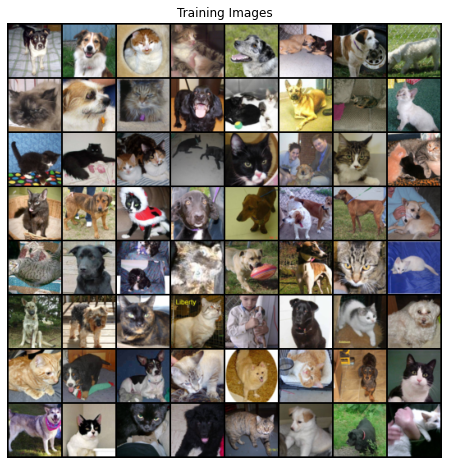

In [11]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [2]:
class Generator1(nn.Module):
    def __init__(self, ngpu):
        super(Generator1, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, ngf // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),
            # state size. (ngf / 2) x 64 x 64
            nn.ConvTranspose2d( ngf // 2, nc, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [19]:
# Create the generator
netG0 = Generator(ngpu).to(device)
netG1 = Generator1(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG0.apply(weights_init)
netG1.apply(weights_init); # LMAO no print

In [21]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [22]:
# Create the Discriminator
netD0 = Discriminator(ngpu).to(device)
netD1 = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD0.apply(weights_init)
netD1.apply(weights_init);

In [29]:
# Training Loop
def train(netG, netD, lr=lr, num_epochs=num_epochs):
    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")

    # Reference time point for how long the training takes
    start_time = time.perf_counter()

    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    # Calculate the amount of time the training took
    elapsed_time = time.perf_counter() - start_time
    
    return img_list, G_losses, D_losses, elapsed_time

In [30]:
def print_elapsed_time(elapsed_time):
    return "{:.0f}h {:02.0f}m {:.3f}s".format(elapsed_time // 3600,
                                              elapsed_time % 3600 // 60,
                                              elapsed_time % 60)

In [25]:
def plot_losses(G_losses, D_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [26]:
def animate_progress(img_list):
    #%%capture
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

In [27]:
def compare_real_gen(dataloader, img_list):
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()

In [31]:
img_list0, G_losses0, D_losses0, elapsed_time0 = train(netG0, netD0, num_epochs=45)
img_list1, G_losses1, D_losses1, elapsed_time1 = train(netG1, netD1, num_epochs=45)

Starting Training Loop...
[0/45][0/184]	Loss_D: 1.9022	Loss_G: 3.1694	D(x): 0.3079	D(G(z)): 0.3420 / 0.0551
[0/45][50/184]	Loss_D: 0.0420	Loss_G: 6.5784	D(x): 0.9626	D(G(z)): 0.0020 / 0.0018
[0/45][100/184]	Loss_D: 0.6004	Loss_G: 6.9105	D(x): 0.9101	D(G(z)): 0.3652 / 0.0029
[0/45][150/184]	Loss_D: 0.7936	Loss_G: 6.0926	D(x): 0.8847	D(G(z)): 0.4428 / 0.0032
[1/45][0/184]	Loss_D: 0.5094	Loss_G: 6.5503	D(x): 0.9245	D(G(z)): 0.3210 / 0.0021
[1/45][50/184]	Loss_D: 0.5885	Loss_G: 6.1544	D(x): 0.8414	D(G(z)): 0.1557 / 0.0046
[1/45][100/184]	Loss_D: 0.4749	Loss_G: 7.4784	D(x): 0.9102	D(G(z)): 0.2313 / 0.0007
[1/45][150/184]	Loss_D: 0.2227	Loss_G: 3.8170	D(x): 0.9022	D(G(z)): 0.1023 / 0.0387
[2/45][0/184]	Loss_D: 0.6111	Loss_G: 2.8767	D(x): 0.6448	D(G(z)): 0.0439 / 0.0970
[2/45][50/184]	Loss_D: 0.6149	Loss_G: 6.0978	D(x): 0.9378	D(G(z)): 0.3953 / 0.0035
[2/45][100/184]	Loss_D: 1.7127	Loss_G: 0.8720	D(x): 0.2844	D(G(z)): 0.0050 / 0.4691
[2/45][150/184]	Loss_D: 0.6848	Loss_G: 3.2105	D(x): 0.6256	

[24/45][100/184]	Loss_D: 0.3887	Loss_G: 3.8578	D(x): 0.9033	D(G(z)): 0.2303 / 0.0283
[24/45][150/184]	Loss_D: 2.7613	Loss_G: 0.3668	D(x): 0.1520	D(G(z)): 0.0234 / 0.7462
[25/45][0/184]	Loss_D: 0.5033	Loss_G: 3.1104	D(x): 0.6979	D(G(z)): 0.0708 / 0.0693
[25/45][50/184]	Loss_D: 0.3929	Loss_G: 3.0822	D(x): 0.7704	D(G(z)): 0.0963 / 0.0662
[25/45][100/184]	Loss_D: 0.4388	Loss_G: 2.3381	D(x): 0.7835	D(G(z)): 0.1492 / 0.1206
[25/45][150/184]	Loss_D: 0.4352	Loss_G: 2.6319	D(x): 0.8457	D(G(z)): 0.2094 / 0.0936
[26/45][0/184]	Loss_D: 0.4414	Loss_G: 4.4425	D(x): 0.9386	D(G(z)): 0.2857 / 0.0167
[26/45][50/184]	Loss_D: 0.4988	Loss_G: 3.3908	D(x): 0.8429	D(G(z)): 0.2501 / 0.0441
[26/45][100/184]	Loss_D: 0.4783	Loss_G: 3.3695	D(x): 0.7697	D(G(z)): 0.1408 / 0.0599
[26/45][150/184]	Loss_D: 0.4192	Loss_G: 2.1696	D(x): 0.7961	D(G(z)): 0.1494 / 0.1419
[27/45][0/184]	Loss_D: 0.7587	Loss_G: 5.1077	D(x): 0.9778	D(G(z)): 0.4667 / 0.0094
[27/45][50/184]	Loss_D: 0.3191	Loss_G: 2.8554	D(x): 0.8171	D(G(z)): 0.090

[4/45][0/184]	Loss_D: 0.5468	Loss_G: 4.4379	D(x): 0.6747	D(G(z)): 0.0215 / 0.0362
[4/45][50/184]	Loss_D: 0.3471	Loss_G: 4.2720	D(x): 0.8355	D(G(z)): 0.1078 / 0.0356
[4/45][100/184]	Loss_D: 0.8279	Loss_G: 1.8426	D(x): 0.5753	D(G(z)): 0.1377 / 0.2306
[4/45][150/184]	Loss_D: 0.3020	Loss_G: 2.9046	D(x): 0.8254	D(G(z)): 0.0740 / 0.0704
[5/45][0/184]	Loss_D: 0.3434	Loss_G: 4.5561	D(x): 0.8662	D(G(z)): 0.1641 / 0.0140
[5/45][50/184]	Loss_D: 0.8358	Loss_G: 3.2827	D(x): 0.8960	D(G(z)): 0.4422 / 0.0754
[5/45][100/184]	Loss_D: 0.5941	Loss_G: 3.0275	D(x): 0.7948	D(G(z)): 0.2617 / 0.0626
[5/45][150/184]	Loss_D: 0.8490	Loss_G: 2.3888	D(x): 0.5953	D(G(z)): 0.1522 / 0.1300
[6/45][0/184]	Loss_D: 0.3550	Loss_G: 3.8484	D(x): 0.8336	D(G(z)): 0.1314 / 0.0325
[6/45][50/184]	Loss_D: 0.2735	Loss_G: 3.4932	D(x): 0.8992	D(G(z)): 0.1239 / 0.0448
[6/45][100/184]	Loss_D: 0.9993	Loss_G: 3.7319	D(x): 0.6071	D(G(z)): 0.2247 / 0.0405
[6/45][150/184]	Loss_D: 0.5147	Loss_G: 2.4011	D(x): 0.7298	D(G(z)): 0.1180 / 0.1363
[

[28/45][100/184]	Loss_D: 0.5705	Loss_G: 1.9685	D(x): 0.7990	D(G(z)): 0.2394 / 0.1856
[28/45][150/184]	Loss_D: 0.5690	Loss_G: 2.3475	D(x): 0.7661	D(G(z)): 0.2233 / 0.1182
[29/45][0/184]	Loss_D: 2.4303	Loss_G: 0.1585	D(x): 0.1488	D(G(z)): 0.0159 / 0.8668
[29/45][50/184]	Loss_D: 0.6300	Loss_G: 2.2551	D(x): 0.6959	D(G(z)): 0.1917 / 0.1382
[29/45][100/184]	Loss_D: 0.9039	Loss_G: 3.8029	D(x): 0.9172	D(G(z)): 0.4973 / 0.0335
[29/45][150/184]	Loss_D: 0.9826	Loss_G: 2.5636	D(x): 0.6844	D(G(z)): 0.3698 / 0.1101
[30/45][0/184]	Loss_D: 0.6878	Loss_G: 2.5777	D(x): 0.7861	D(G(z)): 0.3085 / 0.0962
[30/45][50/184]	Loss_D: 0.9796	Loss_G: 0.6748	D(x): 0.4761	D(G(z)): 0.0877 / 0.5702
[30/45][100/184]	Loss_D: 0.6185	Loss_G: 2.3941	D(x): 0.7834	D(G(z)): 0.2618 / 0.1264
[30/45][150/184]	Loss_D: 0.6626	Loss_G: 2.8293	D(x): 0.8468	D(G(z)): 0.3444 / 0.0816
[31/45][0/184]	Loss_D: 0.6361	Loss_G: 2.0008	D(x): 0.7526	D(G(z)): 0.2404 / 0.1701
[31/45][50/184]	Loss_D: 0.8923	Loss_G: 3.7738	D(x): 0.9049	D(G(z)): 0.475

In [33]:
print("G0 + D0 were trained in ", print_elapsed_time(elapsed_time0))
print("G1 + D1 were trained in ", print_elapsed_time(elapsed_time1))

G0 + D0 were trained in  0h 31m 56.657s
G1 + D1 were trained in  0h 35m 18.615s


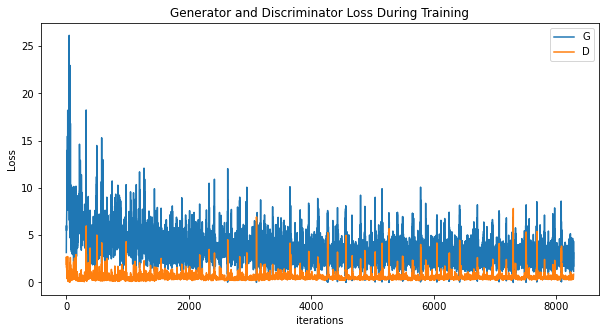

In [34]:
plot_losses(G_losses0, D_losses0)

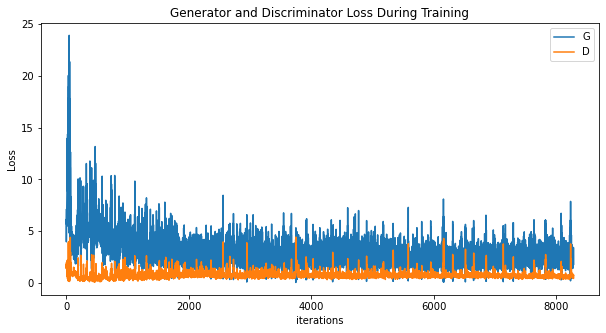

In [35]:
plot_losses(G_losses1, D_losses1)

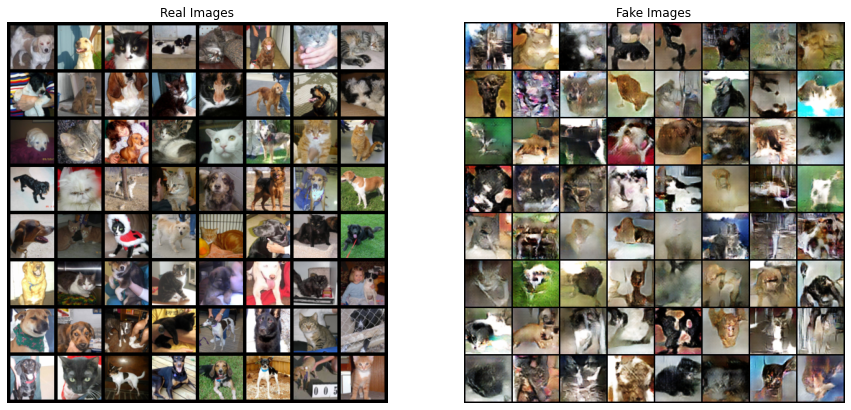

In [36]:
compare_real_gen(dataloader, img_list0)

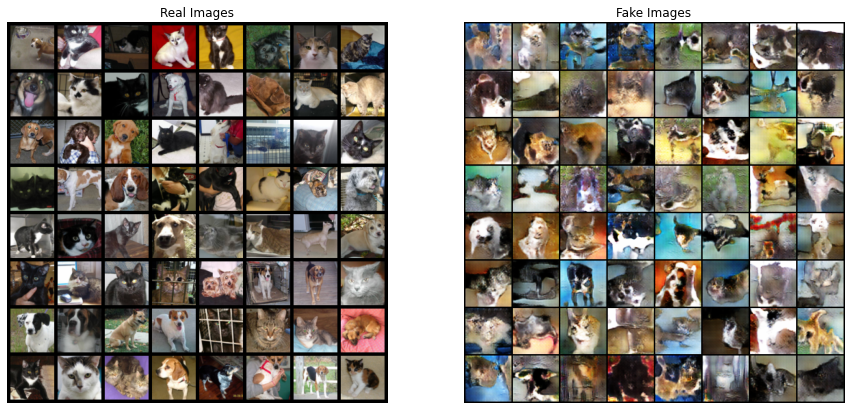

In [37]:
compare_real_gen(dataloader, img_list1)

In [38]:
torch.save(netG0.state_dict(), "netG0")
torch.save(netG1.state_dict(), "netG1")
torch.save(netD0.state_dict(), "netD0")
torch.save(netD1.state_dict(), "netD1")